<a href="https://colab.research.google.com/github/jithsg/2-Pipeline/blob/main/Copy_of_frequency_vtune_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Frequency vs Vtune Voltage Analysis
This notebook analyzes frequency measurements at different Vtune voltages (2.75V, 3V, and 3.25V) across multiple ICs

Detected 20 IC blocks


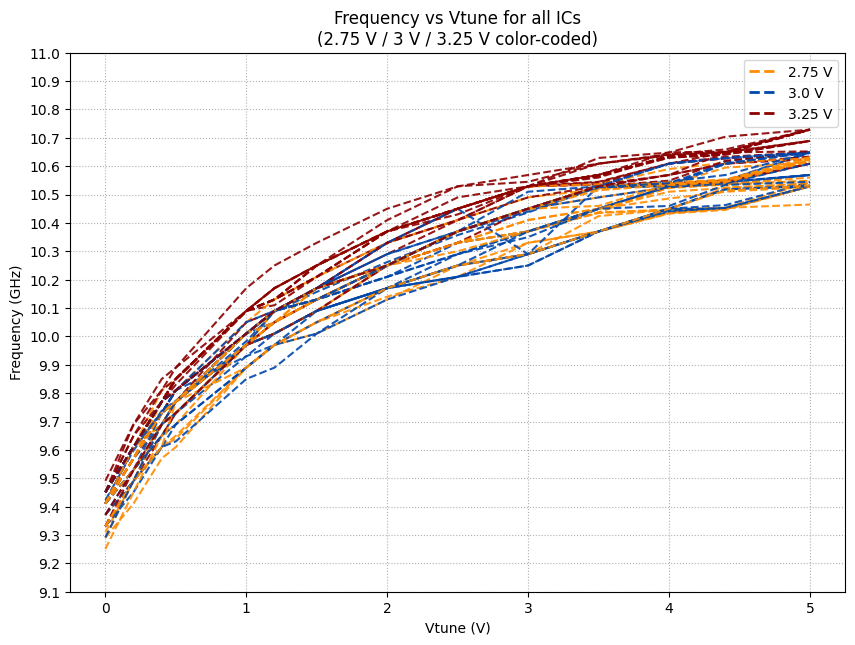

In [13]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load Excel data
# -----------------------------
EXCEL_PATH = "Raw_data_A1.xlsx"
SHEET_NAME = "Vdd_variation"
raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME, header=None)

# -----------------------------
# Detect IC blocks
# -----------------------------
def find_ic_blocks(df):
    starts = []
    for r in range(len(df)):
        val = df.iloc[r, 0]
        if isinstance(val, str) and val.strip().upper().startswith("IC") and r + 4 < len(df):
            vt = df.iloc[r+1, 0]
            v1 = df.iloc[r+2, 0]
            v2 = df.iloc[r+3, 0]
            v3 = df.iloc[r+4, 0]
            if (isinstance(vt, str) and "Vtune" in vt and
                isinstance(v1, str) and "2.75" in v1 and
                isinstance(v2, str) and v2.strip() == "3V" and
                isinstance(v3, str) and "3.25" in v3):
                starts.append(r)
    return starts

IC_STARTS = find_ic_blocks(raw)
print(f"Detected {len(IC_STARTS)} IC blocks")

# -----------------------------
# Extract aligned Vtune and frequency rows (trim after ~6 V)
# -----------------------------
def extract_ic_series(df, r, vt_max=6.0):
    ic_name = str(df.iloc[r, 0]).strip()
    vt   = pd.to_numeric(df.iloc[r+1, 1:], errors='coerce').reset_index(drop=True)
    v275 = pd.to_numeric(df.iloc[r+2, 1:], errors='coerce').reset_index(drop=True)
    v300 = pd.to_numeric(df.iloc[r+3, 1:], errors='coerce').reset_index(drop=True)
    v325 = pd.to_numeric(df.iloc[r+4, 1:], errors='coerce').reset_index(drop=True)

    n = len(vt)
    keep_len = 0
    last = None
    for i in range(n):
        x = vt.iloc[i]
        if not np.isfinite(x) or x > vt_max: break
        if last is not None and x < last - 1e-12: break
        keep_len += 1
        last = x

    vt, v275, v300, v325 = vt.iloc[:keep_len], v275.iloc[:keep_len], v300.iloc[:keep_len], v325.iloc[:keep_len]
    mask = np.isfinite(vt) & np.isfinite(v275) & np.isfinite(v300) & np.isfinite(v325)
    return ic_name, vt[mask].to_numpy(), v275[mask].to_numpy(), v300[mask].to_numpy(), v325[mask].to_numpy()

# -----------------------------
# Combined plot: all ICs, color-coded by Vdd
# -----------------------------
plt.figure(figsize=(10,7))

color_275 = '#FF8C00'   # Dark orange
color_300 = '#0047AB'   # Navy blue
color_325 = '#8B0000'

for r in IC_STARTS:
    ic_name, vt, v275, v300, v325 = extract_ic_series(raw, r)
    plt.plot(vt, v275, '--', color=color_275, alpha=0.9)
    plt.plot(vt, v300, '--', color=color_300, alpha=0.9)
    plt.plot(vt, v325, '--', color=color_325, alpha=0.9)

# Representative legend entries (single per VDD)
plt.plot([], [], '--', color=color_275, linewidth=2, label='2.75 V')
plt.plot([], [], '--', color=color_300, linewidth=2, label='3.0 V')
plt.plot([], [], '--', color=color_325, linewidth=2, label='3.25 V')


plt.xlabel("Vtune (V)")
plt.ylabel("Frequency (GHz)")
plt.title("Frequency vs Vtune for all ICs\n(2.75 V / 3 V / 3.25 V color-coded)")
plt.grid(True, linestyle=':')

# --- Y-axis ticks every 0.1 GHz (≈100 MHz) ---
ymin, ymax = plt.ylim()
plt.yticks(np.arange(np.floor(ymin*10)/10, np.ceil(ymax*10)/10 + 0.1, 0.1))

# Optional: zoom in if you know the range (example)
# plt.ylim(9.2, 10.8)

plt.legend()
plt.show()



Detected 20 IC blocks


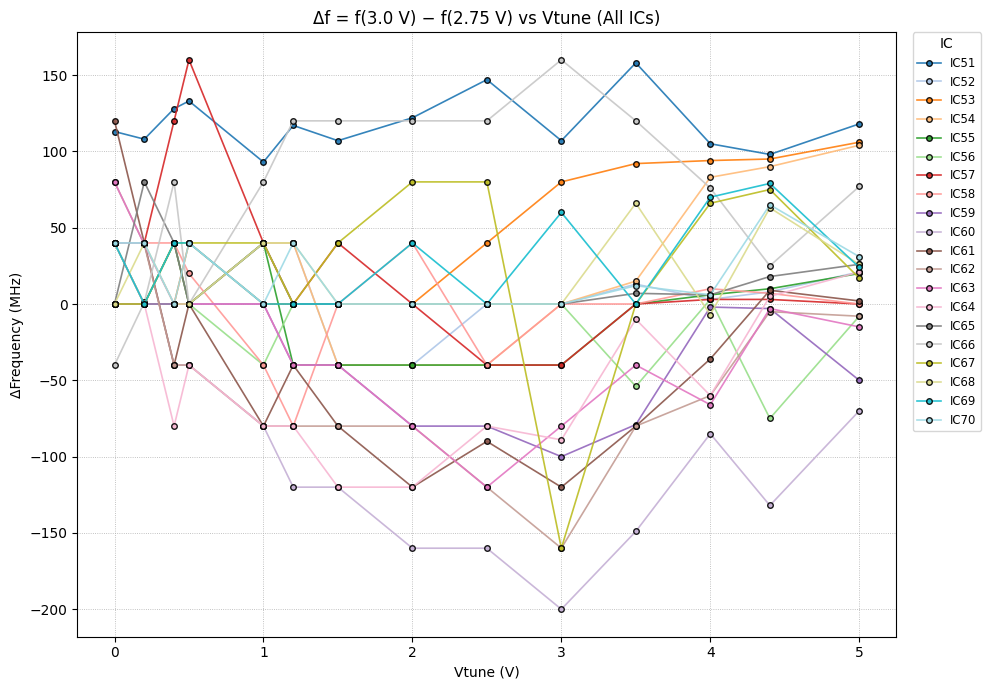

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load Excel sheet
# -----------------------------
EXCEL_PATH = "Raw_data_A1.xlsx"
SHEET_NAME = "Vdd_variation"
raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME, header=None)

# -----------------------------
# Detect IC blocks
# -----------------------------
def find_ic_blocks(df):
    starts = []
    for r in range(len(df)):
        val = df.iloc[r, 0]
        if isinstance(val, str) and val.strip().upper().startswith("IC") and r + 4 < len(df):
            vt = df.iloc[r+1, 0]
            v1 = df.iloc[r+2, 0]
            v2 = df.iloc[r+3, 0]
            v3 = df.iloc[r+4, 0]
            if (isinstance(vt, str) and "Vtune" in vt and
                isinstance(v1, str) and "2.75" in v1 and
                isinstance(v2, str) and v2.strip() == "3V" and
                isinstance(v3, str) and "3.25" in v3):
                starts.append(r)
    return starts

IC_STARTS = find_ic_blocks(raw)
print(f"Detected {len(IC_STARTS)} IC blocks")

# -----------------------------
# Extract Vtune and frequency rows (trim after ~6 V)
# -----------------------------
def extract_ic_series(df, r, vt_max=6.0):
    ic_name = str(df.iloc[r, 0]).strip()
    vt   = pd.to_numeric(df.iloc[r+1, 1:], errors='coerce').reset_index(drop=True)
    v275 = pd.to_numeric(df.iloc[r+2, 1:], errors='coerce').reset_index(drop=True)
    v300 = pd.to_numeric(df.iloc[r+3, 1:], errors='coerce').reset_index(drop=True)
    v325 = pd.to_numeric(df.iloc[r+4, 1:], errors='coerce').reset_index(drop=True)

    # keep first contiguous, non-decreasing Vtune up to vt_max
    n = len(vt)
    keep_len = 0
    last = None
    for i in range(n):
        x = vt.iloc[i]
        if not np.isfinite(x) or x > vt_max: break
        if last is not None and x < last - 1e-12: break
        keep_len += 1
        last = x

    vt, v275, v300 = vt.iloc[:keep_len], v275.iloc[:keep_len], v300.iloc[:keep_len]
    mask = np.isfinite(vt) & np.isfinite(v275) & np.isfinite(v300)
    return ic_name, vt[mask].to_numpy(), v275[mask].to_numpy(), v300[mask].to_numpy()

# -----------------------------
# Task 2 – ONE PLOT with ALL ICs superimposed
# Δf(3.0 V − 2.75 V) shown in MHz
# -----------------------------
plt.figure(figsize=(10,7))
colors = plt.cm.tab20.colors  # 20 distinct colors

for idx, r in enumerate(IC_STARTS):
    ic_name, vt, v275, v300 = extract_ic_series(raw, r)
    diff_mhz = (v300 - v275) * 1e3  # GHz → MHz
    color = colors[idx % len(colors)]
    # solid circles with connecting line
    plt.plot(
        vt, diff_mhz, 'o-', label=ic_name,
        markersize=4, markerfacecolor=color, markeredgecolor='black',
        linewidth=1.2, color=color, alpha=0.9
    )

plt.title("Δf = f(3.0 V) − f(2.75 V) vs Vtune (All ICs)")
plt.xlabel("Vtune (V)")
plt.ylabel("ΔFrequency (MHz)")
plt.grid(True, linestyle=':', linewidth=0.6)

# Put the big legend outside to avoid covering the plot
plt.legend(title="IC", bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0., fontsize='small', ncol=1)
plt.tight_layout()
plt.show()



Detected 20 IC blocks


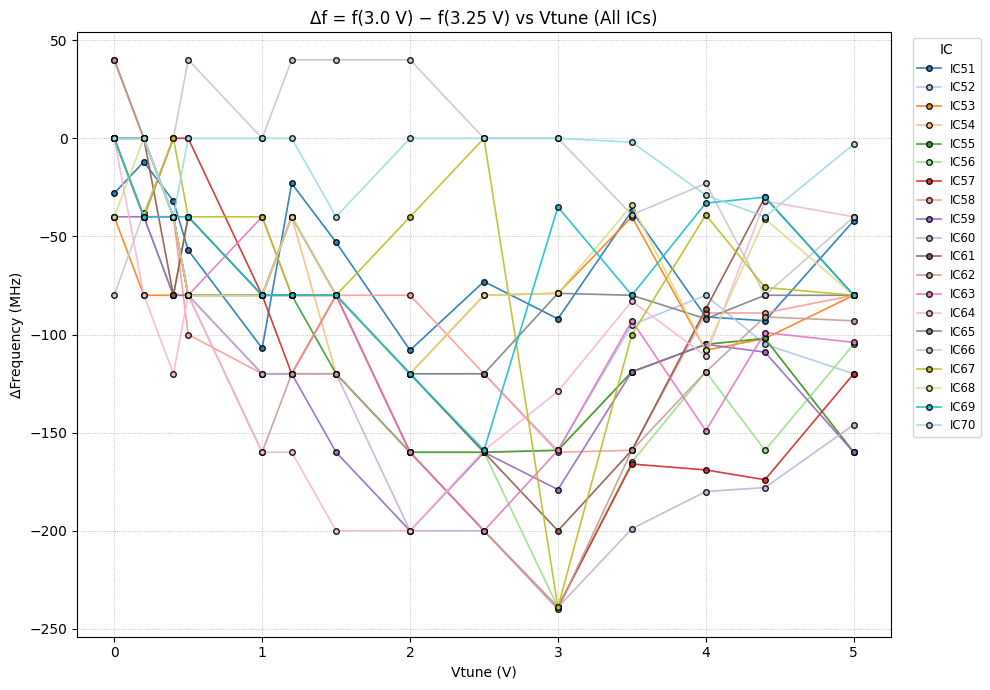

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load Excel data
# -----------------------------
EXCEL_PATH = "Raw_data_A1.xlsx"
SHEET_NAME = "Vdd_variation"
raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME, header=None)

# -----------------------------
# Detect IC blocks
# -----------------------------
def find_ic_blocks(df):
    starts = []
    for r in range(len(df)):
        val = df.iloc[r, 0]
        if isinstance(val, str) and val.strip().upper().startswith("IC") and r + 4 < len(df):
            vt = df.iloc[r+1, 0]
            v1 = df.iloc[r+2, 0]
            v2 = df.iloc[r+3, 0]
            v3 = df.iloc[r+4, 0]
            if (isinstance(vt, str) and "Vtune" in vt and
                isinstance(v1, str) and "2.75" in v1 and
                isinstance(v2, str) and v2.strip() == "3V" and
                isinstance(v3, str) and "3.25" in v3):
                starts.append(r)
    return starts

IC_STARTS = find_ic_blocks(raw)
print(f"Detected {len(IC_STARTS)} IC blocks")

# -----------------------------
# Extract Vtune and frequency rows (trim after ~6 V)
# -----------------------------
def extract_ic_series(df, r, vt_max=6.0):
    ic_name = str(df.iloc[r, 0]).strip()
    vt   = pd.to_numeric(df.iloc[r+1, 1:], errors='coerce').reset_index(drop=True)
    v300 = pd.to_numeric(df.iloc[r+3, 1:], errors='coerce').reset_index(drop=True)
    v325 = pd.to_numeric(df.iloc[r+4, 1:], errors='coerce').reset_index(drop=True)

    n = len(vt)
    keep_len, last = 0, None
    for i in range(n):
        x = vt.iloc[i]
        if not np.isfinite(x) or x > vt_max: break
        if last is not None and x < last - 1e-12: break
        keep_len += 1
        last = x

    vt, v300, v325 = vt.iloc[:keep_len], v300.iloc[:keep_len], v325.iloc[:keep_len]
    mask = np.isfinite(vt) & np.isfinite(v300) & np.isfinite(v325)
    return ic_name, vt[mask].to_numpy(), v300[mask].to_numpy(), v325[mask].to_numpy()

# -----------------------------
# Task 3 – One plot with ALL ICs superimposed
# Δf (3.25 V − 3.0 V) in MHz
# -----------------------------
plt.figure(figsize=(10,7))
colors = plt.cm.tab20.colors  # up to 20 distinct colors

for idx, r in enumerate(IC_STARTS):
    ic_name, vt, v300, v325 = extract_ic_series(raw, r)
    diff_mhz = (v300-v325) * 1e3  # GHz → MHz
    color = colors[idx % len(colors)]
    plt.plot(
        vt, diff_mhz, 'o-', label=ic_name,
        markersize=4, markerfacecolor=color, markeredgecolor='black',
        linewidth=1.2, color=color, alpha=0.9
    )

plt.title("Δf = f(3.0 V) − f(3.25 V) vs Vtune (All ICs)")
plt.xlabel("Vtune (V)")
plt.ylabel("ΔFrequency (MHz)")
plt.grid(True, linestyle=':', linewidth=0.6)
plt.legend(title="IC", bbox_to_anchor=(1.02, 1), loc="upper left", fontsize='small')
plt.tight_layout()
plt.show()


Detected 20 IC blocks


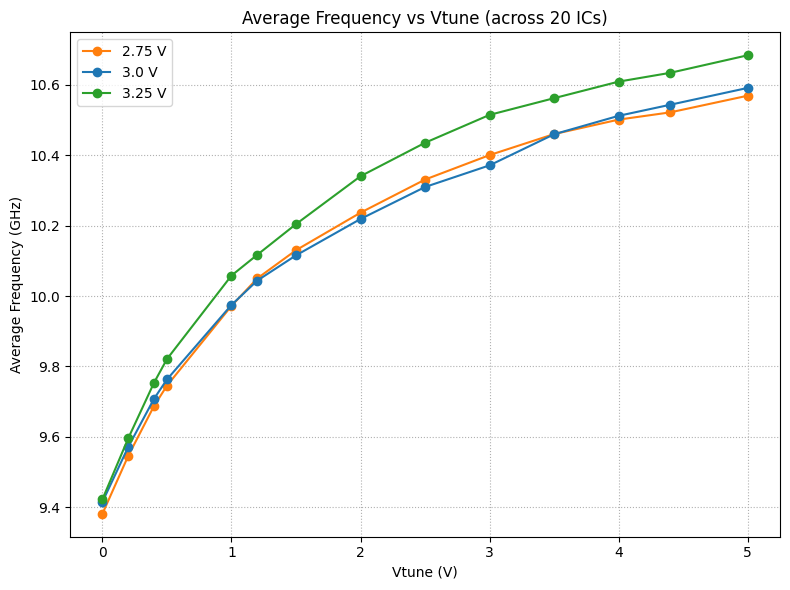

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Load Excel data
# -----------------------------
EXCEL_PATH = "Raw_data_A1.xlsx"
SHEET_NAME = "Vdd_variation"
raw = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME, header=None)

# -----------------------------
# Detect IC blocks
# -----------------------------
def find_ic_blocks(df):
    starts = []
    for r in range(len(df)):
        val = df.iloc[r, 0]
        if isinstance(val, str) and val.strip().upper().startswith("IC") and r + 4 < len(df):
            vt = df.iloc[r+1, 0]
            v1 = df.iloc[r+2, 0]
            v2 = df.iloc[r+3, 0]
            v3 = df.iloc[r+4, 0]
            if (isinstance(vt, str) and "Vtune" in vt and
                isinstance(v1, str) and "2.75" in v1 and
                isinstance(v2, str) and v2.strip() == "3V" and
                isinstance(v3, str) and "3.25" in v3):
                starts.append(r)
    return starts

IC_STARTS = find_ic_blocks(raw)
print(f"Detected {len(IC_STARTS)} IC blocks")

# -----------------------------
# Extract aligned Vtune and frequency rows (trim after ~6 V)
# -----------------------------
def extract_ic_series(df, r, vt_max=6.0):
    ic_name = str(df.iloc[r, 0]).strip()
    vt   = pd.to_numeric(df.iloc[r+1, 1:], errors='coerce').reset_index(drop=True)
    v275 = pd.to_numeric(df.iloc[r+2, 1:], errors='coerce').reset_index(drop=True)
    v300 = pd.to_numeric(df.iloc[r+3, 1:], errors='coerce').reset_index(drop=True)
    v325 = pd.to_numeric(df.iloc[r+4, 1:], errors='coerce').reset_index(drop=True)

    # Keep first contiguous Vtune segment up to 6 V
    n = len(vt)
    keep_len, last = 0, None
    for i in range(n):
        x = vt.iloc[i]
        if not np.isfinite(x) or x > vt_max: break
        if last is not None and x < last - 1e-12: break
        keep_len += 1
        last = x

    vt, v275, v300, v325 = vt.iloc[:keep_len], v275.iloc[:keep_len], v300.iloc[:keep_len], v325.iloc[:keep_len]
    mask = np.isfinite(vt) & np.isfinite(v275) & np.isfinite(v300) & np.isfinite(v325)
    return ic_name, vt[mask].to_numpy(), v275[mask].to_numpy(), v300[mask].to_numpy(), v325[mask].to_numpy()

# -----------------------------
# Combine all ICs to compute average per Vtune
# -----------------------------
vtune_master = None
all_275, all_300, all_325 = [], [], []

for r in IC_STARTS:
    ic_name, vt, v275, v300, v325 = extract_ic_series(raw, r)
    if vtune_master is None:
        vtune_master = vt  # assume same Vtune steps for all ICs
    else:
        # ensure consistent length (some trimming)
        min_len = min(len(vtune_master), len(vt))
        vtune_master = vtune_master[:min_len]
        v275, v300, v325 = v275[:min_len], v300[:min_len], v325[:min_len]
    all_275.append(v275)
    all_300.append(v300)
    all_325.append(v325)

# Convert to arrays and average across ICs (axis=0)
avg_275 = np.nanmean(np.array(all_275), axis=0)
avg_300 = np.nanmean(np.array(all_300), axis=0)
avg_325 = np.nanmean(np.array(all_325), axis=0)

# -----------------------------
# Plot Average Freq vs Vtune for all ICs
# -----------------------------
plt.figure(figsize=(8,6))
plt.plot(vtune_master, avg_275, 'o-', color='tab:orange', label='2.75 V')
plt.plot(vtune_master, avg_300, 'o-', color='tab:blue',  label='3.0 V')
plt.plot(vtune_master, avg_325, 'o-', color='tab:green', label='3.25 V')

plt.xlabel("Vtune (V)")
plt.ylabel("Average Frequency (GHz)")
plt.title("Average Frequency vs Vtune (across 20 ICs)")
plt.grid(True, linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()
